In [1]:
import pandas as pd
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from plot_fairness_metrics import *

pip install 'aif360[inFairness]'


In [2]:
def compute_individual_weights(df, label_col, protected_attr_col):
    """
    Compute weights for a single protected attribute to rebalance joint label/protected group distribution.
    """
    joint_counts = df.groupby([protected_attr_col, label_col]).size().reset_index(name='joint_count')
    attr_counts = df[protected_attr_col].value_counts(normalize=True).reset_index()
    attr_counts.columns = [protected_attr_col, 'attr_prob']
    label_counts = df[label_col].value_counts(normalize=True).reset_index()
    label_counts.columns = [label_col, 'label_prob']

    weights_df = joint_counts.merge(attr_counts, on=protected_attr_col)
    weights_df = weights_df.merge(label_counts, on=label_col)

    weights_df['weight'] = weights_df['attr_prob'] * weights_df['label_prob'] / (weights_df['joint_count'] / len(df))

    return weights_df[[protected_attr_col, label_col, 'weight']]

def compute_combined_weights(df, label_col, protected_attrs):
    """
    Compute instance weights by multiplying individual fairness weights across multiple protected attributes.
    """
    df = df.copy()
    df['weight'] = 1.0  # Start with neutral weights

    for attr in protected_attrs:
        w = compute_individual_weights(df, label_col, attr)
        w = w.rename(columns={'weight': f'weight_{attr}'})
        df = df.merge(w, on=[attr, label_col], how='left')
        df['weight'] *= df[f'weight_{attr}']

    return df


In [3]:
from sklearn.preprocessing import QuantileTransformer

def remove_disparate_impact_global(df, features, protected_attr, repair_level=0.5):
    df = df.copy()
    
    for feature in features:
        repaired_col = f"{feature}_repaired"
        df[repaired_col] = np.nan

        # Global reference distribution
        qt_global = QuantileTransformer(output_distribution='normal')
        global_transformed = qt_global.fit_transform(df[[feature]]).flatten()

        df[f"{feature}_quantile"] = global_transformed  # for interpolation

        for group in df[protected_attr].unique():
            group_mask = df[protected_attr] == group
            original = df.loc[group_mask, feature]
            transformed = df.loc[group_mask, f"{feature}_quantile"]
            repaired = (1 - repair_level) * original + repair_level * transformed
            df.loc[group_mask, repaired_col] = repaired

        df.drop(columns=[f"{feature}_quantile"], inplace=True)

    return df


In [4]:
from sklearn.preprocessing import QuantileTransformer
import pandas as pd
import numpy as np

def remove_disparate_impact(df, features, protected_attr, repair_level=1.0):

    df = df.copy()
    for feature in features:
        repaired_col = f"{feature}_repaired"
        df[repaired_col] = np.nan
        
        for group in df[protected_attr].unique():
            group_mask = df[protected_attr] == group
            group_values = df.loc[group_mask, feature].values.reshape(-1, 1)
            
            qt = QuantileTransformer(output_distribution='normal')
            transformed = qt.fit_transform(group_values).flatten()
            
            original = df.loc[group_mask, feature]
            repaired = (1 - repair_level) * original + repair_level * transformed
            
            df.loc[group_mask, repaired_col] = repaired

    return df


In [5]:
df = pd.read_csv('peranna2.csv')
df_copied = df.copy()
predicted_cols = ['pass_bar_lr', 'pass_bar_lr_weighted',
       'pass_bar_lr_best', 'pass_bar_rf', 'pass_bar_xgb', 'pass_bar_xgb_r']
df.drop(columns=predicted_cols, inplace=True)

In [6]:
race_enc = LabelEncoder()
df['race1_encoded'] = race_enc.fit_transform(df['race1'])

In [7]:
race_mapping = dict(zip(race_enc.classes_, race_enc.transform(race_enc.classes_)))
print(race_mapping)

{'asian': 0, 'black': 1, 'hisp': 2, 'other': 3, 'white': 4}


In [8]:
nokeep = ['bar', 'race2', 'race1']
keep = list(set(df.columns) - set(nokeep))
df = df[keep]

In [9]:
features = ['male', 'decile1', 'decile3', 'lsat', 'ugpa', 'zfygpa', 'zgpa', 'parttime', 'fam_inc', 'tier', 'race1_black', 'race1_hisp', 'race1_other', 'race1_white', 'race1_encoded']

target = 'pass_bar'

X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

In [10]:
df_train = X_train.copy()
df_train[target] = y_train
df_test = X_test.copy()
df_test[target] = y_test

In [11]:
new_features = ['male', 'decile1', 'decile3', 'lsat', 'ugpa', 'zfygpa', 'zgpa', 'parttime', 'race1_encoded_repaired', 'tier_repaired', 'fam_inc_repaired']

In [12]:
df_train_rw = df_train.copy()
df_train_rw['race1_encoded_repaired'] = remove_disparate_impact(df_train, ['race1_encoded'], 'race1_encoded')['race1_encoded_repaired']
df_train_rw['tier_repaired'] = remove_disparate_impact(df_train, ['tier'], 'tier')['tier_repaired']
df_train_rw['fam_inc_repaired'] = remove_disparate_impact(df_train, ['fam_inc'], 'fam_inc')['fam_inc_repaired']

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (814). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (711). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (324). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (475). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\annad\AppData\Local

In [13]:
protected_features = ['race1_encoded', 'tier', 'fam_inc']
df_train_rw = compute_combined_weights(df_train_rw, label_col='pass_bar', protected_attrs=protected_features)

In [14]:
X_train_rw = df_train_rw[new_features]
y_train_rw = df_train_rw[target]

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score


fbeta_scorer = make_scorer(fbeta_score, beta=1.41, pos_label=0)

param_grid = {
    'max_depth': [3, 5, 8, 10, None],
    'min_samples_split': [2, 5, 10]
}

clf = GridSearchCV(
    RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced', min_samples_leaf=2),
    param_grid,
    scoring=fbeta_scorer,  
    cv=5
)
clf.fit(X_train_rw, y_train_rw, sample_weight=df_train_rw['weight'])

print("Best max_depth:", clf.best_params_['max_depth'])
print("Best min_samples_split:", clf.best_params_['min_samples_split'])

Best max_depth: 10
Best min_samples_split: 10


In [16]:
rf_best_model = clf.best_estimator_

In [17]:
# from sklearn.metrics import confusion_matrix, classification_report


# y_test_pred = lr_best_model.predict(X_test)

# print(confusion_matrix(y_test, y_test_pred))
# print(classification_report(y_test, y_test_pred))

### on whole dataset

In [18]:
df_rw = df.copy()
df_rw['race1_encoded_repaired'] = remove_disparate_impact_global(df, ['race1_encoded'], 'race1_encoded')['race1_encoded_repaired']
df_rw['tier_repaired'] = remove_disparate_impact_global(df, features=['tier'], protected_attr='tier', repair_level=1.0)['tier_repaired']
df_rw['fam_inc_repaired'] = remove_disparate_impact_global(df, features=['fam_inc'], protected_attr='fam_inc', repair_level=1.0)['fam_inc_repaired']

In [19]:
df_rw

,parttime,grad,bar2_yr,race1_encoded,race1_black,decile1,race,decile3,bar1_yr,race1_white,...,bar2,zfygpa,race1_hisp,zgpa,fam_inc,tier,race1_other,race1_encoded_repaired,tier_repaired,fam_inc_repaired
0,0.0,1,94.0,4,False,10.0,7.0,10.0,7.0,True,...,1,1.33,False,1.88,5.0,4.0,False,4.599669,0.251016,5.199338
1,0.0,1,94.0,4,False,5.0,7.0,4.0,7.0,True,...,1,-0.11,False,-0.57,4.0,2.0,False,4.599669,-1.509656,0.523537
2,0.0,1,94.0,4,False,3.0,7.0,2.0,7.0,True,...,1,-0.64,False,-1.12,1.0,3.0,False,4.599669,-0.570161,-5.199338
3,0.0,1,94.0,4,False,7.0,7.0,4.0,7.0,True,...,1,0.34,False,-0.49,4.0,3.0,False,4.599669,-0.570161,0.523537
4,0.0,1,94.0,4,False,9.0,7.0,8.0,7.0,True,...,1,1.02,False,0.76,4.0,5.0,False,4.599669,0.922330,0.523537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22067,0.0,1,95.0,1,True,3.0,3.0,1.0,2.0,False,...,0,-0.58,False,-1.49,2.0,1.0,False,-0.235777,-5.199338,-1.467860
22068,0.0,1,94.0,1,True,3.0,3.0,1.0,7.0,False,...,0,-0.64,False,-1.36,3.0,1.0,False,-0.235777,-5.199338,-0.523537
22069,1.0,1,95.0,1,True,7.0,3.0,8.0,7.0,False,...,1,0.41,False,0.80,3.0,3.0,False,-0.235777,-0.570161,-0.523537
22070,1.0,1,95.0,4,False,10.0,7.0,10.0,7.0,True,...,1,1.88,False,1.42,3.0,3.0,False,4.599669,-0.570161,-0.523537


In [20]:
pass_bar_rf_dir = rf_best_model.predict(df_rw[new_features])
df_rw['pass_bar_rf_dir'] = pass_bar_rf_dir

In [21]:
df_rw

,parttime,grad,bar2_yr,race1_encoded,race1_black,decile1,race,decile3,bar1_yr,race1_white,...,zfygpa,race1_hisp,zgpa,fam_inc,tier,race1_other,race1_encoded_repaired,tier_repaired,fam_inc_repaired,pass_bar_rf_dir
0,0.0,1,94.0,4,False,10.0,7.0,10.0,7.0,True,...,1.33,False,1.88,5.0,4.0,False,4.599669,0.251016,5.199338,1
1,0.0,1,94.0,4,False,5.0,7.0,4.0,7.0,True,...,-0.11,False,-0.57,4.0,2.0,False,4.599669,-1.509656,0.523537,1
2,0.0,1,94.0,4,False,3.0,7.0,2.0,7.0,True,...,-0.64,False,-1.12,1.0,3.0,False,4.599669,-0.570161,-5.199338,1
3,0.0,1,94.0,4,False,7.0,7.0,4.0,7.0,True,...,0.34,False,-0.49,4.0,3.0,False,4.599669,-0.570161,0.523537,1
4,0.0,1,94.0,4,False,9.0,7.0,8.0,7.0,True,...,1.02,False,0.76,4.0,5.0,False,4.599669,0.922330,0.523537,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22067,0.0,1,95.0,1,True,3.0,3.0,1.0,2.0,False,...,-0.58,False,-1.49,2.0,1.0,False,-0.235777,-5.199338,-1.467860,0
22068,0.0,1,94.0,1,True,3.0,3.0,1.0,7.0,False,...,-0.64,False,-1.36,3.0,1.0,False,-0.235777,-5.199338,-0.523537,0
22069,1.0,1,95.0,1,True,7.0,3.0,8.0,7.0,False,...,0.41,False,0.80,3.0,3.0,False,-0.235777,-0.570161,-0.523537,1
22070,1.0,1,95.0,4,False,10.0,7.0,10.0,7.0,True,...,1.88,False,1.42,3.0,3.0,False,4.599669,-0.570161,-0.523537,1


In [22]:
print(df_rw['race1_encoded_repaired'].describe())
print(df_rw['race1_encoded_repaired'].nunique())
print(df_rw['race1_encoded_repaired'].value_counts())

count    22072.000000
mean         3.766225
std          1.952867
min         -2.599669
25%          4.599669
50%          4.599669
75%          4.599669
max          4.599669
Name: race1_encoded_repaired, dtype: float64
5
race1_encoded_repaired
 4.599669    18462
-0.235777     1308
 0.420242     1010
-2.599669      888
 0.993763      404
Name: count, dtype: int64


In [23]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
import pandas as pd

def compute_disparate_impact_by_race(df, label_col='pass_bar', race_col='race1_encoded', white_label=4):
    results = []

    # Filter all unique race codes except White (reference group)
    race_codes = sorted(df[race_col].unique())
    other_races = [r for r in race_codes if r != white_label]

    for group in other_races:
        # Create dataset with only White and one comparison group
        df_pair = df[df[race_col].isin([white_label, group])].copy()
        df_pair[race_col + '_bin'] = df_pair[race_col].apply(lambda x: 1 if x == white_label else 0)

        dataset = BinaryLabelDataset(
            favorable_label=1,
            unfavorable_label=0,
            df=df_pair,
            label_names=[label_col],
            protected_attribute_names=[race_col + '_bin']
        )

        metric = BinaryLabelDatasetMetric(
            dataset,
            privileged_groups=[{race_col + '_bin': 1}],  # White
            unprivileged_groups=[{race_col + '_bin': 0}]  # Current group
        )

        di = metric.disparate_impact()

        results.append({
            'Group': f'{group} vs White',
            'Disparate Impact': di
        })

    return pd.DataFrame(results)

di_results = compute_disparate_impact_by_race(df_rw, label_col='pass_bar_rf_dir', race_col='race1_encoded', white_label=4)
print(di_results)

        Group  Disparate Impact
0  0 vs White          0.840239
1  1 vs White          0.494724
2  2 vs White          0.698632
3  3 vs White          0.818971


In [24]:
results_all = {}

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

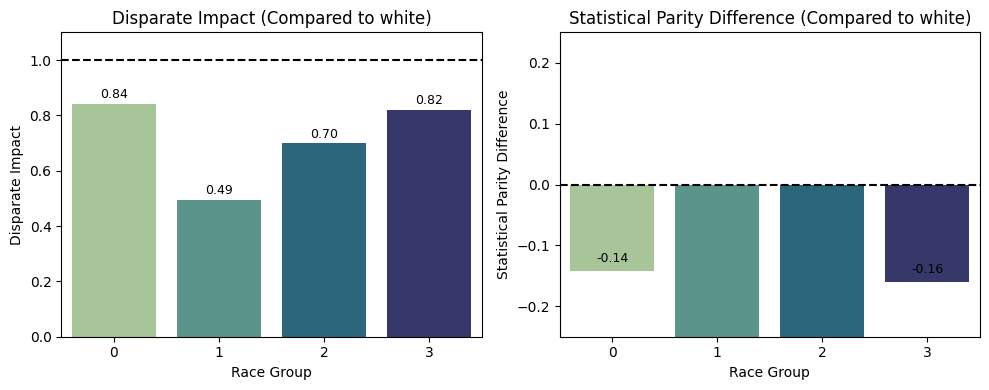

In [25]:
race_groups = [0, 1, 2, 3]
results = get_DI_SPD_WD(race_groups, df_rw, 'race1_encoded', 4, 'pass_bar_rf_dir')
plot_fairness_metrics(results, 'Race Group', 'white')
results_all['Race'] = results

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

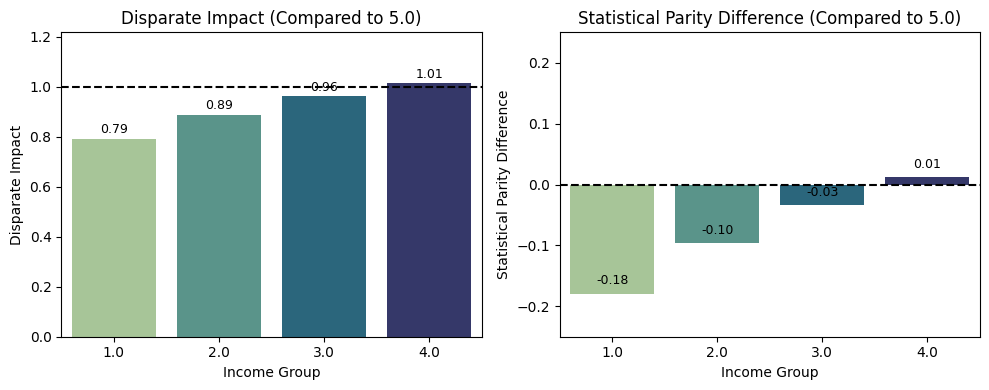

In [26]:
income_groups = [1.0, 2.0, 3.0, 4.0]
results = get_DI_SPD_WD(income_groups, df_rw, 'fam_inc', 5.0, 'pass_bar_rf_dir')
plot_fairness_metrics(results, 'Income Group', 5.0)
results_all['Family Income'] = results

c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\annad\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

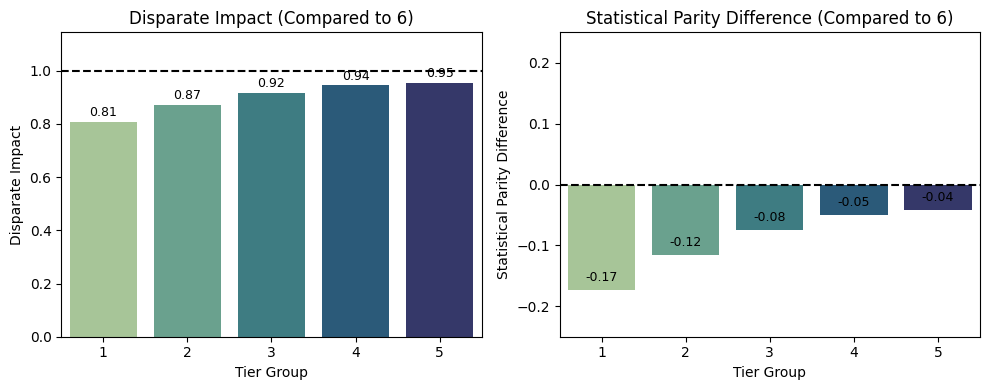

In [27]:
tier_groups = [1, 2, 3, 4, 5]
results = get_DI_SPD_WD(tier_groups, df_rw, 'tier', 6, 'pass_bar_rf_dir')
plot_fairness_metrics(results, 'Tier Group', 6)
results_all['Tier'] = results

In [28]:
results_all

{'Race': {0: {'Disparate Impact': 0.8402394622601876,
   'Statistical Parity Difference': -0.14196033049624213},
  1: {'Disparate Impact': 0.49472358225982793,
   'Statistical Parity Difference': -0.4489795056346833},
  2: {'Disparate Impact': 0.698632329554199,
   'Statistical Parity Difference': -0.26778987290994294},
  3: {'Disparate Impact': 0.818970912635305,
   'Statistical Parity Difference': -0.16085917984063602}},
 'Family Income': {1.0: {'Disparate Impact': 0.7919276151577036,
   'Statistical Parity Difference': -0.17903635982017785},
  2.0: {'Disparate Impact': 0.8885686212212142,
   'Statistical Parity Difference': -0.09588138493927523},
  3.0: {'Disparate Impact': 0.9613053169334894,
   'Statistical Parity Difference': -0.033294928617626285},
  4.0: {'Disparate Impact': 1.0148206601222605,
   'Statistical Parity Difference': 0.01275247092704146}},
 'Tier': {1: {'Disparate Impact': 0.80729231500447,
   'Statistical Parity Difference': -0.17390460726193946},
  2: {'Disparate

## Method explanation
The methods which work for logistic regression do not work for random forest or xgboost, as the latter two are much more complex and less gullible with predictions. The combination of custom weights to the prediction and the before talked about disparate impact remover does make a big difference compared to the bias observed originally but the results are not satisfactory in terms of the 80% threshold mentioned, aside of what is seen in the tier group. 

